# Анализ оттока клиентов в банке

Распространённая проблема банков и других оказывающих услуги организаций и сервисов — это отток клиентов. Индикаторы оттока зависят от специфики отрасли. Как правило, в банках считают, что клиент-физическое лицо попадает в отток, если он в течение определенного периода времени не пользуется сервисами банка, в частности, не совершает операций по своим счетам, закрывает депозиты и т.п. 

**Цель проекта** - решение проблемы с оттоком клиентов регионального банка. Для этого анализируется клиентская база и определяется портрет клиентов, склонных уходить из банка. В ходе работы выполняется ряд **задач**:
- проведение исследовательского анализа данных;
- определение портретов клиентов, склонных к оттоку;
- проверка статистической гипотезы о различии дохода между теми клиентами, которые ушли, и теми, которые остались;
- предоставление заказчику рекомендаций для стратегии взаимодействия с клиентами и их удержания.
---

Импорт библиотек, которые потребуются для выполнения исследования:

In [103]:
import pandas as pd
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import scipy

# Загрузка файла и изучение общей информации

Считывание файла с данными из Google Sheets по ссылке и импорт в датафрейм:

In [2]:
file_name = 'https://docs.google.com/spreadsheets/d/1c_PvPQ9HPp7QxBa7nfRfKhRjXqqLXOj4OP4q2bbaD2g/export?format=csv'
r = requests.get(file_name)
bank_clients = pd.read_csv(BytesIO(r.content))

Получение данных о первых 10 строках таблицы **bank_clients**:

In [3]:
bank_clients.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Общая информация о данных таблицы **bank_clients**:

In [4]:
bank_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В датафрейме **bank_clients** представлена информация о клиентах банка. В нем 12 столбцов: 

- **userid** - идентификатор пользователя / целочисл. тип данных
- **score** - баллы кредитного скоринга / целочисл. тип данных
- **City** - город / строковый тип данных
- **Gender** - пол / строковый тип данных
- **Age** - возраст / целочисл. тип данных
- **Objects** - количество объектов в собственности / целочисл. тип данных
- **Balance** - баланс на счете / числа с плав. точкой
- **Products** - количество продуктов, которыми пользуется клиент / целочисл. тип данных
- **CreditCard** - факт наличия кредитной карты / целочисл. тип данных
- **Loyalty** - активный клиент / целочисл. тип данных
- **estimated_salary** - заработная плата / числа с плав. точкой
- **Churn** - факт оттока / целочисл. тип данных

Общее количество записей о посетителях - 10 000. Пропуски есть в столбце **Balance** (пропущено 3 617 значений).

---

# Предобработка данных

Подготовим исходные данные для дальнейшего исседования и построения прогноза.

#### Переименование столбцов

Переименуем столбцы в соответствии с общепринятой практикой:

In [5]:
bank_clients.columns = bank_clients.columns.str.lower()
bank_clients.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

#### Удаление дубликатов

Проверим таблицу на наличие полностью повторяющихся строк:

In [6]:
bank_clients.duplicated().sum()

0

Полных дубликатов в данных нет. 

Также убедимся, что отсутствуют повторяющиеся значения в столбце **userid**, поскольку подразумевается, что они должны быть уникальны:

In [7]:
bank_clients['userid'].duplicated().sum()

0

Записей с одинаковым id и разными значениями признаков в таблице также нет.

#### Приведение типов данных

Преобразуем категориальные переменные строкового типа для удобства последующей работы с ними.

Во-первых, переменной **gender** присвоим значение 1 для клиентов-мужчин и 0 - для женщин, убедившись сначала, что переменная принимает только два значения:

In [8]:
bank_clients['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

In [9]:
bank_clients['gender'] = [1 if (i == 'М') else 0 for i in bank_clients['gender']]

In [10]:
bank_clients['gender'].value_counts()

1    5457
0    4543
Name: gender, dtype: int64

Во-вторых, представим столбец **city** в виде нескольких бинарных с помощью функции *get_dummies()*:

In [11]:
bank_clients = pd.get_dummies(bank_clients)
display(bank_clients.head())

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,0,42,2,NaN,1,1,1,101348.88,1,0,0,1
1,15690047,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15662040,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,93826.63,0,0,0,1
4,15780624,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0


И еще раз переименуем столбцы, убрав пробелы:

In [12]:
bank_clients.columns = bank_clients.columns.str.replace(" ", "_")

#### Обработка пропущенных значений

Пропуски встречаются в единственном столбце **balance**. Данные есть в 6 383 строках вместо ожидаемых 10 000. Это слишком много, чтобы без ущерба удалить соответствующие строки. Попробуем восстановить недостающие значения.

In [13]:
bank_clients['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

Посмотрим на записи с пропусками:

In [14]:
bank_clients.loc[bank_clients['balance'].isna()].head(15)

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов_Великий,city_Рыбинск,city_Ярославль
0,15677338,619,0,42,2,NaN,1,1,1,101348.88,1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,93826.63,0,0,0,1
6,15635267,822,1,50,7,NaN,2,1,1,10062.80,0,0,0,1
11,15779909,497,1,24,3,NaN,2,1,0,76390.01,0,0,1,0
12,15675000,476,0,34,10,NaN,2,1,0,26260.98,0,0,0,1
13,15734219,549,0,25,5,NaN,2,0,0,190857.79,0,0,0,1
14,15643618,635,0,35,7,NaN,2,1,1,65951.65,0,0,1,0
17,15830954,549,0,24,9,NaN,2,1,1,14406.41,0,0,1,0
18,15704243,587,1,45,6,NaN,1,0,0,158684.81,0,0,1,0
19,15611718,726,0,24,6,NaN,2,1,1,54724.03,0,0,0,1


Навскидку связи пропусков со значениями других признаков не видно. Обратим внимание на то, что минимальное значение в столбце **balance** - 3768,69. Маловероятно, что в выборку, которую мы изучаем на предмет оттока, вообще не попали клиенты с нулевыми остатками на счетах, но это действительно так: 

In [15]:
bank_clients.query('balance == 0')['userid'].count()

0

В таком случае скорее всего вместо нулевых остатков стоят пропуски, однако обратное - каждый пропуск соответствует нулевому значению - вообще говоря, утверждать нет оснований. Пропущенные значения могли появиться, например, из-за технических ошибок при переносе данных.

Из всех имеющихся признаков показатель остатка наиболее тесно связан с показателем активности. Будем предполагать, что у активного клиента скорее всего есть и движение по расчетному счету, и остатки. Заполним нулями только те пропуски, где клиент не является активным. Таких строк 1744: 

In [16]:
bank_clients.loc[(bank_clients['balance'].isna()) & (bank_clients['loyalty'] == 0)].shape[0]

1744

In [17]:
bank_clients.loc[(bank_clients['balance'].isna()) & (bank_clients['loyalty'] == 0), 'balance'] = 0

Пропусков осталось по-прежнему очень много:

In [18]:
bank_clients.loc[bank_clients['balance'].isna()].shape[0]

1873

Однако поскольку замена пропусков на среднее значение (и тем более на нулевое) по выборке может сильно исказить ее статистические свойства, оставим датафрейм в таком виде.

#### Вывод

Были произведены следующие преобразования:
- названия столбцов изменены в соответствии с общепринятой практикой;
- часть пропусков в столбце **balance** заменена нулевыми значенмями;
- категориальные переменные **gender** и **city** переведены в бинарные поля.

# Исследовательский анализ данных

Теперь рассмотрим отдельно каждый столбец на предмет наличия ошибок в данных, аномалий и пр. Начнем с основного показателя (в дальнейшем - целевой переменной) - оттока.

**churn - факт оттока**

In [19]:
bank_clients['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

В отток попало около 20% клиентов.

In [20]:
ch = bank_clients.groupby(by = 'churn').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
ch['label'] = ['Нет' if (i == 0) else 'Да' for i in ch['churn']]

In [21]:
def show_percent(figure, shift, height):
#вспомогательная функция для отображения процентов на графике
#принимает на вход название графика, сдвиг надписи по горизонтали и по вертикали
    
    totals = []
    for i in figure.patches:
        totals.append(i.get_height())
    
    total = sum(totals)

    for i in figure.patches:
        figure.text(i.get_x() + shift, i.get_height() + height, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12,
                color = 'black')

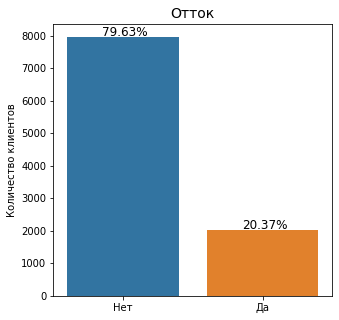

In [22]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = ch) 
fig.set_title("Отток", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [23]:
bank_clients['churn'].describe()

count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

Среднее значение - 0,20. Стандартное отклонение - 0,40.

Для дальнейшего удобства разобьем датасет на две группы - тех, кто ушел в отток, и тех, кто не ушел:

In [24]:
churn_clients = bank_clients.query('churn == 1')
nonchurn_clients = bank_clients.query('churn == 0')

Будем рассматривать признаки в разрезе оттока.

**userid - идентификатор пользователя**

Данный признак не имеет отношения к показателю оттока - это всего лишь набор уникальных чисел для идентификации клиентов. Дубликатов среди записей нет, как мы выяснили выше. Значения id лежат среди чисел:

In [25]:
display(bank_clients['userid'].min())
display(bank_clients['userid'].max())

15608437

15858426

**score - баллы кредитного скоринга**

In [26]:
bank_clients['score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

Самый низкий кредитный рейтинг - 350 баллов, самый высокий - 850. Среднее значение - 650,5 баллов, что практически совпадает с медианой (652), стандартное отклонение - 96,6.

Построим график распределения:

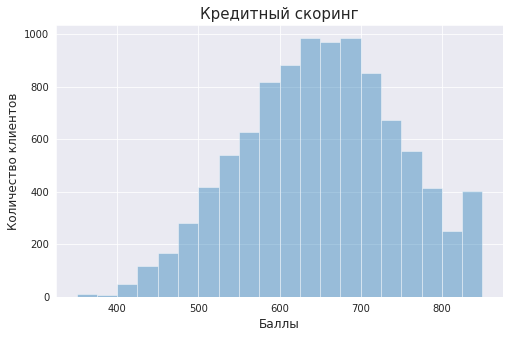

In [27]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(bank_clients['score'], kde = False, bins = 20)
fig.set_title("Кредитный скоринг", fontsize = 15)
fig.set_xlabel("Баллы", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

Распределение соответствует нормальному, за исключением правого края, где наблюдается неожиданно высокое количество клиентов с самым высоким кредитным рейтингом.

Среднее значение признака **score** несколько выше в группе без оттока:

In [28]:
churn_clients['score'].mean().round(3)

645.351

In [29]:
nonchurn_clients['score'].mean().round(3)

651.853

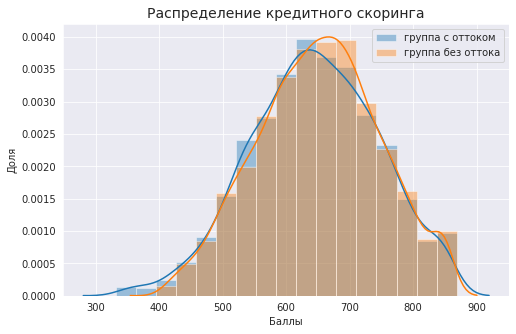

In [30]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['score'], kde = True, \
                    bins = np.linspace(start = 300, stop = 900, num = 20), label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['score'], kde = True, \
                    bins = np.linspace(start = 300, stop = 900, num = 20), label = 'группа без оттока')  
fig2.set_title("Распределение кредитного скоринга", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Баллы")
plt.legend()
plt.show()

Кривые плотностей распределения практически накладываются друг на друга, небольшое различие наблюдается только возле вершины "колоколов": пик графика группы без оттока немного выше и правее пика графика группы с оттоком. Как мы уже видели, среднее значение кредитного рейтинга в группе без оттока немного больше (651,8 против 645,3).

**city - город**

В выборке представлены клиенты из трех городов. Половина из Ярославля и по 25% из Ростова Великого и Рыбинска:

In [31]:
q1 = bank_clients['city_Ростов_Великий'].sum()
print('Количество клиентов из Ростова Великого:', q1)
q2 = bank_clients['city_Рыбинск'].sum()
print('Количество клиентов из Рыбинска:', q2)
q3 = bank_clients['city_Ярославль'].sum()
print('Количество клиентов из Ярославля:', q3)

Количество клиентов из Ростова Великого: 2509
Количество клиентов из Рыбинска: 2477
Количество клиентов из Ярославля: 5014


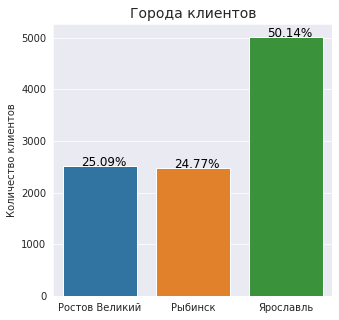

In [32]:
plt.figure(figsize=(5, 5))
temp_df = pd.DataFrame({'name': ['Ростов Великий','Рыбинск','Ярославль'], 'n' : [q1, q2, q3]})
fig = sns.barplot(x = "name", y = "n", data = temp_df);
fig.set_title("Города клиентов", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.20, 0.01)

Теперь посмотрим, каково соотношение клиентов из разных городов в разрезе оттока:

In [33]:
print('Группа с оттоком')
cq1 = churn_clients['city_Ростов_Великий'].sum()
print('Количество клиентов из Ростова Великого:', cq1)
cq2 = churn_clients['city_Рыбинск'].sum()
print('Количество клиентов из Рыбинска:', cq2)
cq3 = churn_clients['city_Ярославль'].sum()
print('Количество клиентов из Ярославля:', cq3)

Группа с оттоком
Количество клиентов из Ростова Великого: 814
Количество клиентов из Рыбинска: 413
Количество клиентов из Ярославля: 810


In [34]:
print('Группа без оттока')
ncq1 = nonchurn_clients['city_Ростов_Великий'].sum()
print('Количество клиентов из Ростова Великого:', ncq1)
ncq2 = nonchurn_clients['city_Рыбинск'].sum()
print('Количество клиентов из Рыбинска:', ncq2)
ncq3 = nonchurn_clients['city_Ярославль'].sum()
print('Количество клиентов из Ярославля:', ncq3)

Группа без оттока
Количество клиентов из Ростова Великого: 1695
Количество клиентов из Рыбинска: 2064
Количество клиентов из Ярославля: 4204


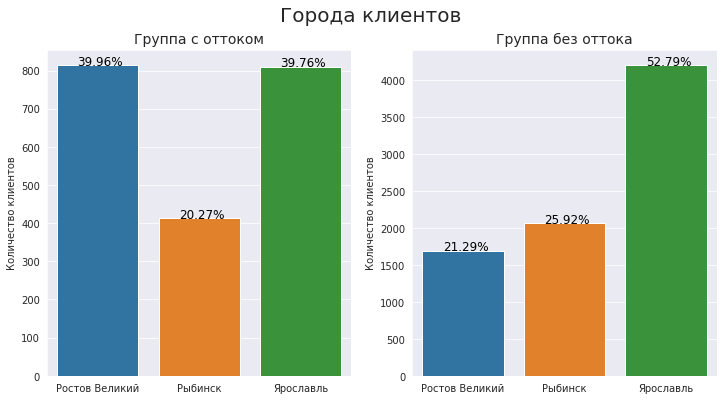

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Города клиентов', fontsize = 20)

temp_df1 = pd.DataFrame({'name': ['Ростов Великий','Рыбинск','Ярославль'], 'n' : [cq1, cq2, cq3]})
fig1 = sns.barplot(ax = axes[0], x = "name", y = "n", data = temp_df1);
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.20, 0.5)

temp_df2 = pd.DataFrame({'name': ['Ростов Великий','Рыбинск','Ярославль'], 'n' : [ncq1, ncq2, ncq3]})
fig2 = sns.barplot(ax = axes[1], x = "name", y = "n", data = temp_df2);
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.20, 0.5)

plt.show()

В группе с оттоком по 40% клиентов из Ростова Великого и Ярославля, а из Рыбинска только 20%. В группе без оттока 53% состоавляют клиенты из Ярославля, 26% из Рыбинска, а меньше всего клиентов из Ростова (21%).

**gender - пол**

In [36]:
bank_clients['gender'].value_counts()

1    5457
0    4543
Name: gender, dtype: int64

54,6% выборки - клиенты-мужчины, а 45,4% - соответственно, женщины.

In [37]:
gend = bank_clients.groupby(by = 'gender').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
gend['label'] = ['Ж' if (i == 0) else 'М' for i in gend['gender']]

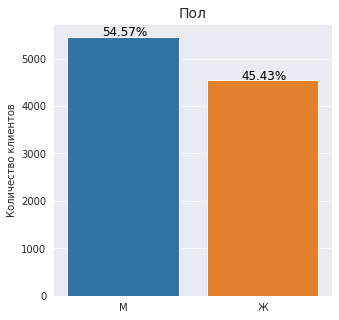

In [38]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = gend) 
fig.set_title("Пол", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [39]:
bank_clients['gender'].describe()

count    10000.000000
mean         0.545700
std          0.497932
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

Среднее значение - 0,546. Стандартное отклонение - 0,497.

Средние значения признака **gender** в группах с оттоком и без оттока отличаются:

In [40]:
churn_clients['gender'].mean().round(3)

0.441

In [41]:
nonchurn_clients['gender'].mean().round(3)

0.573

In [42]:
gend_c = churn_clients.groupby(by = 'gender').agg({'churn' : 'count'}).reset_index()\
                         .rename(columns = {'churn':'n'}).sort_values(by = 'n', ascending = False)
gend_nc = nonchurn_clients.groupby(by = 'gender').agg({'churn' : 'count'}).reset_index()\
                         .rename(columns = {'churn':'n'}).sort_values(by = 'n', ascending = False)
gend_c['label'] = ['Ж' if (i == 0) else 'М' for i in gend_c['gender']]
gend_nc['label'] = ['Ж' if (i == 0) else 'М' for i in gend_nc['gender']]

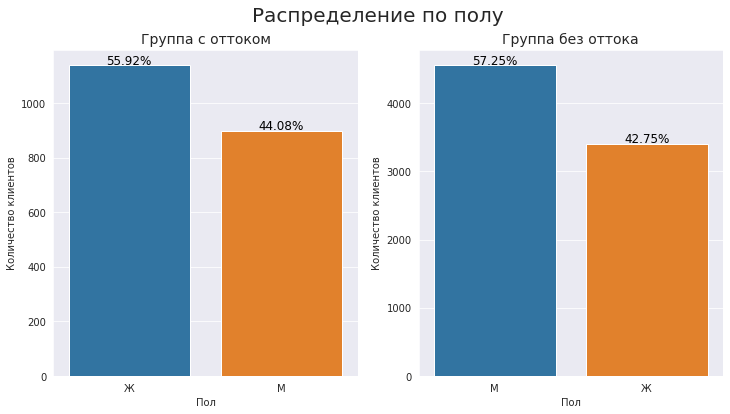

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Распределение по полу', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = gend_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("Пол")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = gend_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Пол")
show_percent(fig2, 0.25, 20)

plt.show()

В группе с оттоком доля женщин выше - 56% против 44% мужчин. В группе без оттока, напротив, больше доля мужчин (57,2%).

**age - возраст**

In [44]:
bank_clients['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Самому молодому клиенту 18 лет, а самому возрастному - 92 года. Средний возраст посетиелей почти 40 лет, стандартное отклонение - 10,5 лет.

Построим график распределения:

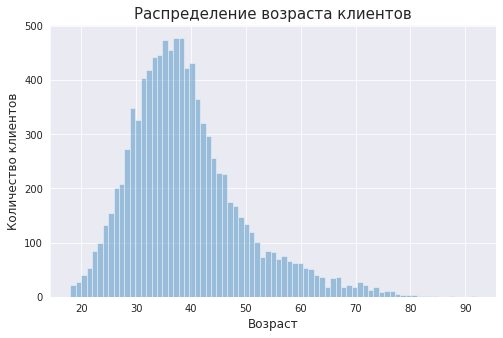

In [45]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(bank_clients['age'], kde = False, bins = bank_clients['age'].max() - bank_clients['age'].min() + 1)
fig.set_title("Распределение возраста клиентов", fontsize = 15)
fig.set_xlabel("Возраст", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

Распределение соответствует нормальному, скошенному вправо. Пожилых клиентов меньше по сравнению с другими возрастными группами.

Среднее значение признака **age** на 7,5 лет выше в группе с оттоком:

In [46]:
churn_clients['age'].mean().round(3)

44.838

In [47]:
nonchurn_clients['age'].mean().round(3)

37.408

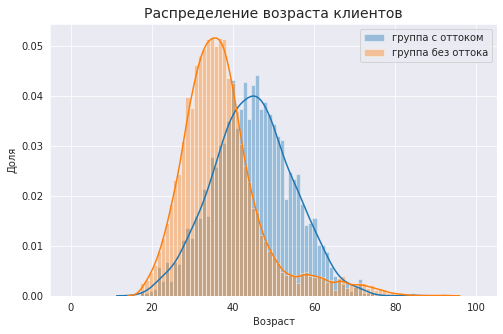

In [48]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['age'], kde = True, \
                    bins = np.linspace(start = 0, stop = 100, num = 100), label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['age'], kde = True, \
                    bins = np.linspace(start = 0, stop = 100, num = 100), label = 'группа без оттока')  
fig2.set_title("Распределение возраста клиентов", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Возраст")
plt.legend()
plt.show()

Видно существенное отличие графиков плотностей распределения возраста в группе с оттоком. В группе без оттока, во-первых, меньше среднее значение. Во-вторых, сам "колокол" более узкий, т.е. меньше разброс от среднего. В-третьих, правый край длинный и узкий, т.е. доля людей старшего возраста (примерно от 50 лет) ощутимо ниже в этой группе.

**objects - количество объектов в собственности**

In [49]:
bank_clients['objects'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: objects, dtype: float64

Минимальное число объектов в собственности - 0, максимальное - 10, среднее (и медианное) - 5. Стандартное отклонение - 2,89.

Построим график распределения:

In [50]:
obj = bank_clients.groupby(by = 'objects').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)

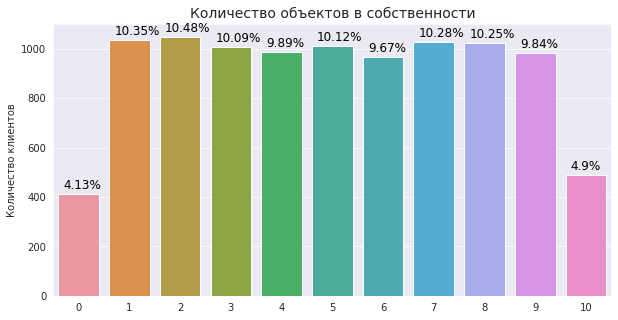

In [51]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "objects", y = "n", data = obj) 
fig.set_title("Количество объектов в собственности", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.1, 20)

Примерно равное количество клиентов владеют одним, двумя, тремя и т.д. до девяти объектов. Нет собственности вообще у 4,1%, 10 объектов - у 4,9%.

Среднее значение признака **objects** всего на 0,1 выше в группе без оттока:

In [52]:
churn_clients['objects'].mean().round(3)

4.933

In [53]:
nonchurn_clients['objects'].mean().round(3)

5.033

In [54]:
obj_c = churn_clients.groupby(by = 'objects').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
obj_nc = nonchurn_clients.groupby(by = 'objects').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)

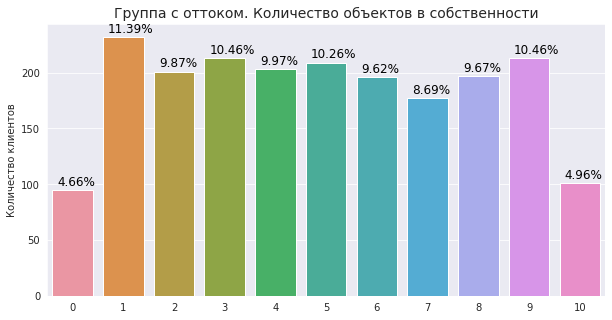

In [55]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "objects", y = "n", data = obj_c) 
fig.set_title("Группа с оттоком. Количество объектов в собственности", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.1, 4)
plt.show()

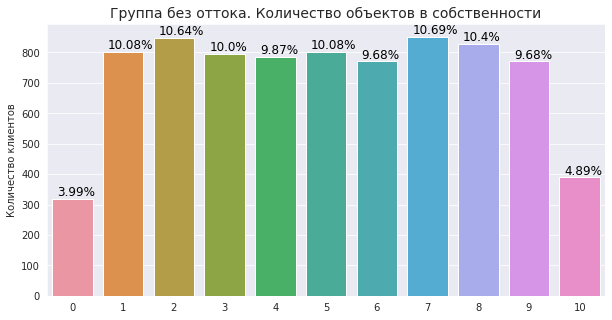

In [56]:
plt.figure(figsize=(10, 5))
fig = sns.barplot(x = "objects", y = "n", data = obj_nc) 
fig.set_title("Группа без оттока. Количество объектов в собственности", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.1, 10)
plt.show()

Существенной разницы между группами не наблюдается. В группе с оттоком на 1,5% выше доля клиентов с единственным объектом в собственности, а также ниже доля клиентов с семью (на 2%) и восемью объектами (на 0,8%).

**balance - баланс на счете**

In [57]:
bank_clients['balance'].describe()

count      8127.000000
mean      94113.312770
std       55961.354844
min           0.000000
25%       68844.215000
50%      109346.130000
75%      133306.505000
max      250898.090000
Name: balance, dtype: float64

Минимальное значение остатка - 0 р., максимальное - 250 898 р. Аномальных значений нет. Среднее значение - 94 113,31 р., медианное - 109 346,13 р. Стандартное отклонение - 55 961 р.

Построим график распределения:

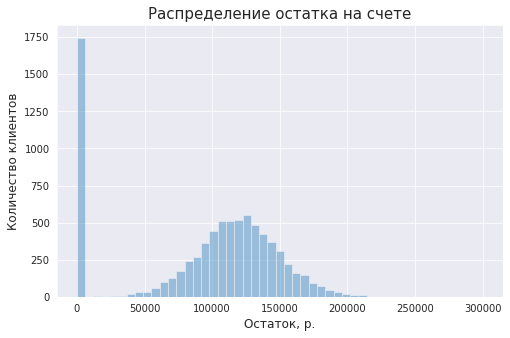

In [58]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(bank_clients['balance'], kde = False, bins = np.linspace(start = 0, stop = 300000, num = 50))
fig.set_title("Распределение остатка на счете", fontsize = 15)
fig.set_xlabel("Остаток, р.", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

В целом распределение выглядит как нормальное, за исключением нулевых значений, которые выше были заполнены вручную.

Среднее значение признака **balance** несколько больше в группе с оттоком:

In [59]:
churn_clients['balance'].mean().round(3)

99939.739

In [60]:
nonchurn_clients['balance'].mean().round(3)

92387.687

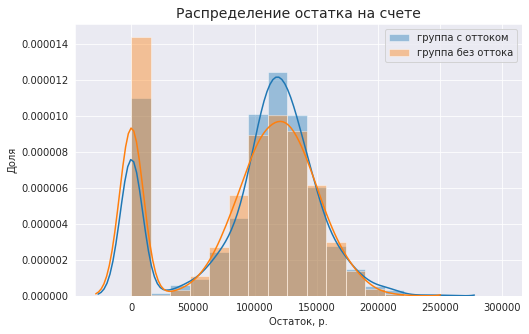

In [61]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['balance'], kde = True, \
                    bins = np.linspace(start = 0, stop = 300000, num = 20), label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['balance'], kde = True, \
                    bins = np.linspace(start = 0, stop = 300000, num = 20), label = 'группа без оттока')  
fig2.set_title("Распределение остатка на счете", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Остаток, р.")
plt.legend()
plt.show()

Распределения выглядят похоже. Стоит отметить, что доля клиентов с нулевыми остатками выше в группе без оттока. На основной части графика пик, соответствующий средним значениям, выше для группы с оттоком.

**products - количество продуктов, которыми пользуется клиент**

In [62]:
bank_clients['products'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: products, dtype: float64

Минимальное количество продуктов, которыми пользуется клиент, - 1, максимальное - 4 среднее - 1,5, медианное - 2. Стандартное отклонение - 0,58.

Построим график распределения:

In [63]:
prod = bank_clients.groupby(by = 'products').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)

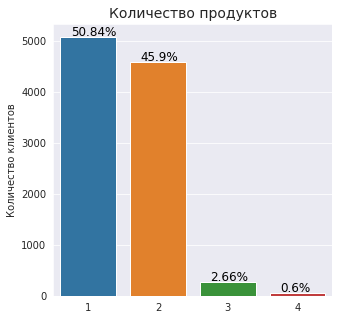

In [64]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "products", y = "n", data = prod) 
fig.set_title("Количество продуктов", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.15, 20)

У половины клиентов оформлен только один продукт, еще у 46% - 2. Незначительное количество пользуется тремя или четырьмя продуктами.

Среднее значение признака **products** несильно отличается в пользу группы без оттока:

In [65]:
churn_clients['products'].mean().round(3)

1.475

In [66]:
nonchurn_clients['products'].mean().round(3)

1.544

In [67]:
prod_c = churn_clients.groupby(by = 'products').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
prod_nc = nonchurn_clients.groupby(by = 'products').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)

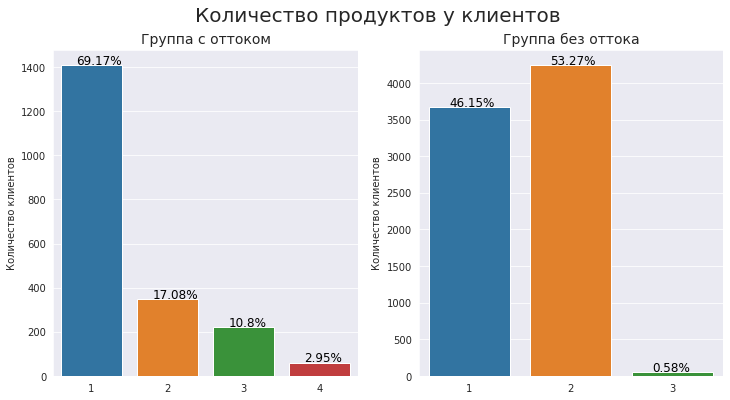

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Количество продуктов у клиентов', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "products", y = "n", data = prod_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.2, 5)

fig2 = sns.barplot(ax = axes[1], x = "products", y = "n", data = prod_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.2, 10)

plt.show()

Подавляющее большинство клиентов (69%) в группе с оттоком пользуется только одним продуктом. В группе без оттока, напротив, 53% используют 2 продукта. В последнюю практически не попали клиенты с тремя или четырьмя продуктами. Вероятно, это можно объяснить тем, что доля таких клиентов в целом очень мала. Все же большее количество продуктов сильнее привязывает покупателя к сервису.

**creditcard - факт наличия кредитной карты**

In [69]:
bank_clients['creditcard'].value_counts()

1    7055
0    2945
Name: creditcard, dtype: int64

70,5% клиентов из выборки имеют кредитные карты.

In [70]:
cards = bank_clients.groupby(by = 'creditcard').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
cards['label'] = ['Нет' if (i == 0) else 'Да' for i in cards['creditcard']]

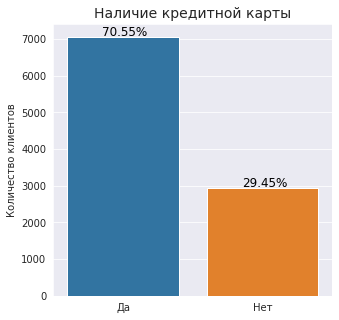

In [71]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = cards) 
fig.set_title("Наличие кредитной карты", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [72]:
bank_clients['creditcard'].describe()

count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: creditcard, dtype: float64

Среднее значение - 0,546. Стандартное отклонение - 0,497.

Средние значения признака **creditcard** в группах с оттоком и без оттока практически не отличаются:

In [73]:
churn_clients['creditcard'].mean().round(3)

0.699

In [74]:
nonchurn_clients['creditcard'].mean().round(3)

0.707

In [75]:
cards_c = churn_clients.groupby(by = 'creditcard').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
cards_nc = nonchurn_clients.groupby(by = 'creditcard').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
cards_c['label'] = ['Нет' if (i == 0) else 'Да' for i in cards_c['creditcard']]
cards_nc['label'] = ['Нет' if (i == 0) else 'Да' for i in cards_nc['creditcard']]

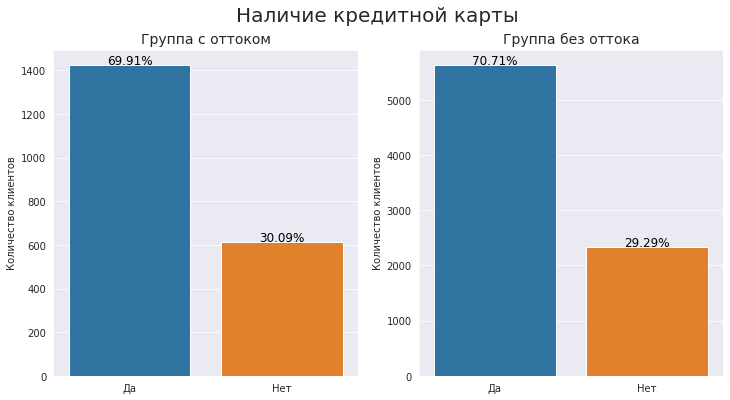

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Наличие кредитной карты', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = cards_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = cards_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

Распределения идентичны для обеих групп.

**loyalty - активный клиент**

In [77]:
bank_clients['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

51,5% клиентов являются активными.

In [78]:
lo = bank_clients.groupby(by = 'loyalty').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
lo['label'] = ['Нет' if (i == 0) else 'Да' for i in lo['loyalty']]

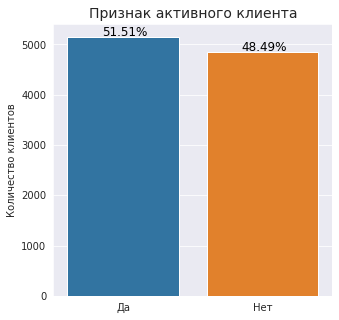

In [79]:
plt.figure(figsize=(5, 5))
fig = sns.barplot(x = "label", y = "n", data = lo) 
fig.set_title("Признак активного клиента", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.25, 20)

In [80]:
bank_clients['loyalty'].describe()

count    10000.000000
mean         0.515100
std          0.499797
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: loyalty, dtype: float64

Среднее значение - 0,515. Стандартное отклонение - 0,5.

Средние значения признака **loyalty** в группах с оттоком и без оттока существенно отличаются:

In [81]:
churn_clients['loyalty'].mean().round(3)

0.361

In [82]:
nonchurn_clients['loyalty'].mean().round(3)

0.555

In [83]:
lo_c = churn_clients.groupby(by = 'loyalty').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
lo_nc = nonchurn_clients.groupby(by = 'loyalty').agg({'userid' : 'count'}).reset_index()\
                         .rename(columns = {'userid':'n'}).sort_values(by = 'n', ascending = False)
lo_c['label'] = ['Нет' if (i == 0) else 'Да' for i in lo_c['loyalty']]
lo_nc['label'] = ['Нет' if (i == 0) else 'Да' for i in lo_nc['loyalty']]

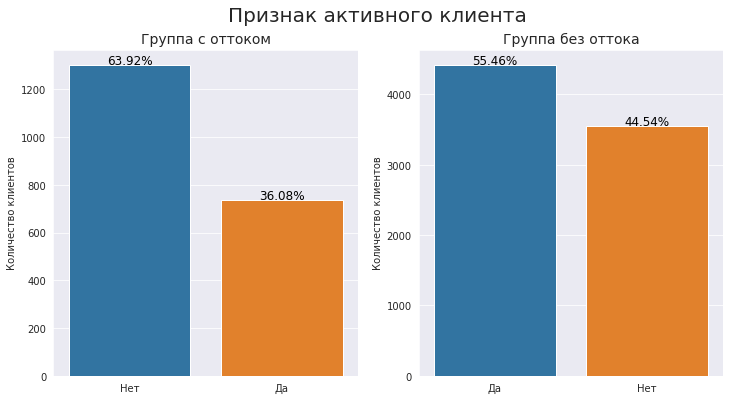

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Признак активного клиента', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "label", y = "n", data = lo_c) 
fig1.set_title("Группа с оттоком", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.25, 5)

fig2 = sns.barplot(ax = axes[1], x = "label", y = "n", data = lo_nc) 
fig2.set_title("Группа без оттока", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.25, 20)

plt.show()

В группе без оттока доля активных клиентов выше - 44,5% против 36% в группе с оттоком.

**estimated_salary - заработная плата**

In [85]:
bank_clients['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Минимальное значение зарплаты - 11,58 р., максимальное - 199 992,48 р. Верхняя граница вопросов не вызывает, а нижняя выглядит неправдоподобной. Из предоставленных данных неясно, каким образом определяется показатель, кроме очевидного случая, когда клиент получает напрямую зарплату на карту в банке заказчика. Возможно, при расчете показателя учитывались поступления на счет, приходящие с определенной периодичностью, тогда под заработной платой стоит понимать пенсию или пособия. Так, например [ежемесячное пособие на первого ребенка в Ярославле](https://yamo.adm.yar.ru/social/soc/soc_zawita2.php) составляет менее 2 500 р. Посмотрим, сколько клиентов с низкими значениями показателя: 

In [86]:
bank_clients.query('estimated_salary < 2500')['userid'].count()

133

Таких всего 1,3% от общего количества, что не должно искажать общую картину, даже если показатель ошибочно занижен. Не будем корректировать данные.

Средний размер зарплаты - 100 090, 24 р., он совпадает с медианным - 100 193,9 р. Стандартное отклонение - 57 510,5 р.

Построим график распределения:

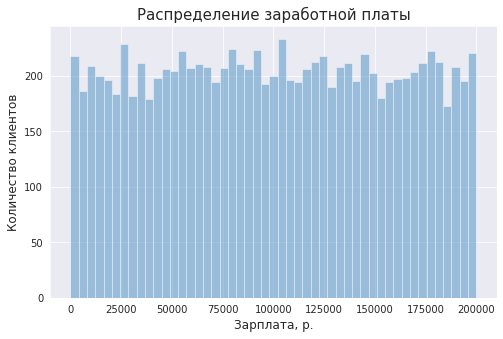

In [87]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(bank_clients['estimated_salary'], kde = False, bins = np.linspace(start = 0, stop = 200000, num = 50))
fig.set_title("Распределение заработной платы", fontsize = 15)
fig.set_xlabel("Зарплата, р.", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

Распределение зарплаты совершенно не похоже на нормальное. В рассматриваемой выборке количество клиентов, получающее зарплату в том или ином сегменте, примерно равное для каждого такого сегмента.

Среднее значение признака **estimated_salary** незначительно выше в группе с оттоком:

In [88]:
churn_clients['estimated_salary'].mean().round(3)

101465.678

In [89]:
nonchurn_clients['estimated_salary'].mean().round(3)

99738.392

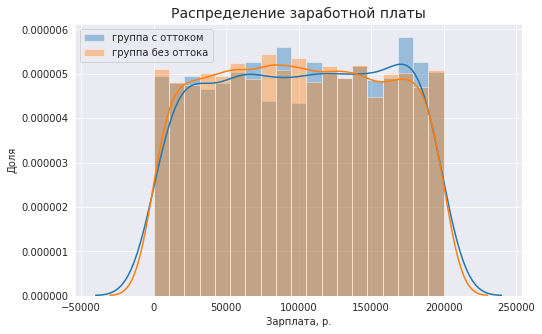

In [90]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(churn_clients['estimated_salary'], kde = True, \
                    bins = np.linspace(start = 0, stop = 200000, num = 20), label = 'группа с оттоком') 
fig2 = sns.distplot(nonchurn_clients['estimated_salary'], kde = True, \
                    bins = np.linspace(start = 0, stop = 200000, num = 20), label = 'группа без оттока')  
fig2.set_title("Распределение заработной платы", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Зарплата, р.")
plt.legend()
plt.show()

Распределения выглядят практически идентично, разницы между группами нет.

#### Вывод

В ходе предварительного анализа было выявлено следующее:
- группа клиентов в оттоке составляет 20% от всей выборки; 
- демографические признаки (пол, возраст, город проживания) сильнее оказывают влияние на отток, чем экономические. Так, группа с оттоком практически не отличается от группы без оттока по доле клиентов, имеющих кредитную карту, или по распределению зарплат, кредитного рейтинга, числу объектов в собственности;
- из экономических параметров только два - число продуктов и активность - оказывают влияние на отток.

О степени влияния рассмотренных показателей речь пойдет в следующем разделе.

# Матрица корреляции и анализ признаков, наиболее влияющих на отток

Выведем таблицу со средними значениями и стандартными отклонениями всех признаков, а также таблицу со средними значениями признаков в группах с оттоком и без:

In [91]:
bank_clients.drop(columns = ['userid']).describe().loc[['mean', 'std']]

,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов_Великий,city_Рыбинск,city_Ярославль
mean,650.528800,0.545700,38.921800,5.012800,94113.312770,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.501400
std,96.653299,0.497932,10.487806,2.892174,55961.354844,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.500023


In [92]:
print('Группа с оттоком:')
display(churn_clients.drop(columns = ['userid']).describe().loc[['mean']])
print('Группа без оттока:')
display(nonchurn_clients.drop(columns = ['userid']).describe().loc[['mean']])

Группа с оттоком:


,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов_Великий,city_Рыбинск,city_Ярославль
mean,645.351497,0.440844,44.837997,4.932744,99939.738627,1.475209,0.699067,0.360825,101465.677531,1.0,0.399607,0.202749,0.397644


Группа без оттока:


,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов_Великий,city_Рыбинск,city_Ярославль
mean,651.853196,0.572523,37.408389,5.033279,92387.687121,1.544267,0.707146,0.554565,99738.391772,0.0,0.212859,0.259199,0.527942


Сравнивая средние значения в группах с оттоком и без, можно заметить ощутимую разницу для следующих признаков:
- пол (в группе без оттока больше мужчин (57% против 44%));
- возраст (клиенты в группе без оттока моложе (средний возраст 37,4 года против 44,8 лет));
- активность (выше в группе без оттока (55% против 36%));
- город (доля жителей Ярославля существенно выше в группе без оттока, а жителей Ростова - напротив, в группе с оттоком).

#### Матрица корреляции

Построим матрицу корреляции признаков и целевой переменной:

In [93]:
cm = bank_clients.drop('userid', 1).corr()

In [94]:
features = ['кредитный рейтинг', 'пол', 'возраст', 'количество объектов собственности', 'остаток', 'количество продуктов',\
            'наличие кредитной карты', 'активность', 'зарплата', 'отток', 'житель Ростова', 'житель Рыбинска',\
            'житель Ярославля']

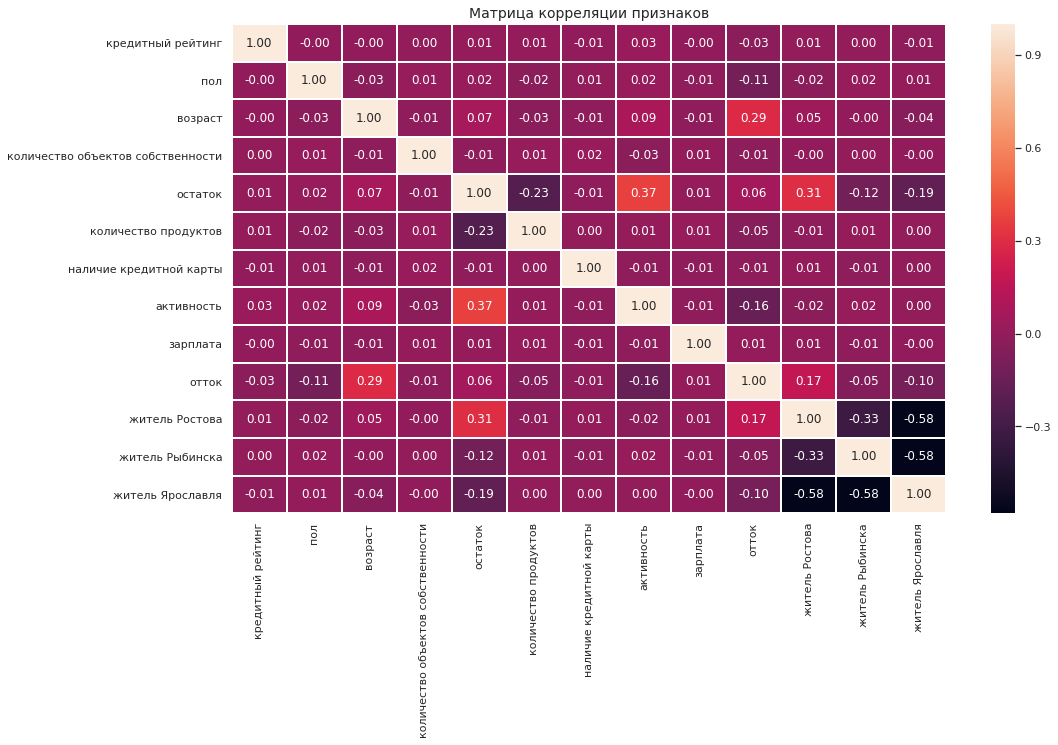

In [95]:
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Матрица корреляции признаков', fontsize = 14)
ax = sns.heatmap(cm, annot = True, linewidths = 1, linecolor = 'white', fmt = '.2f', xticklabels = features,\
                 yticklabels = features)
plt.show()

С помощью матрицы корреляции можно сделать следующие заключения, которые подтверждают выводы,полученные в ходе исследования каждого признака по отдельности в разрезе оттока:
- ни с одной из переменных у показателя оттока нет сильной корреляции. Максимальное значение коэффициента корреляции (по модулю) - с показателем возраст (0,29);
- также наблюдается слабая корреляция между оттоком и полом (-0,11), активностью клиентов (-0,16), проживанием в Ростове (0,17) и Ярославле (-0,1);
- взаимосвязью между оттоком и остальными признаками можно пренебречь;
- есть сильная корреляция показателей, характеризующих город клиента (очевидно, что они линейно зависимы - по построению переменных);
- остатки на счетах положительно коррелируют с признаком активного клиента (0,37%), поскольку именно на основании значений этой переменной мы восстанавливали пропуски в датасете, а также с признаком проживания в Ростове (0,31%) и отрицательно (-0,23) - с количеством продуктов, которыми пользуется клиент.

#### Вывод

- сильнее всего признак оттока связан с возрастом клиентов (положительная корреляция 0,29); 
- имеет место слабая связь между оттоком и полом (-0,11), активностью клиентов (-0,16), проживанием в Ростове (0,17) и Ярославле (-0,1)
- ни одну из вышеупомянутых корреляций нельзя охарактеризовать как сильную;
- взаимосвязью между оттоком и остальными признаками можно пренебречь. 

Таким образом, можно описать **портрет типичного клиента, склонного к уходу из банка**:
- женщина около 45 лет или старше;
- имеет маркер неактивного клиента;
- проживает в Ростове;
- пользуется единственным продуктом банка.
     

# Проверка гипотезы о различии дохода между ушедшими и оставшимися клиентами

С помощью статистического теста выясним, различаются ли заработные платы у ушедших и оставшихся клиентов.

**Нулевая гипотеза**: "Средние заработные платы у клиентов из группы с оттоком и без оттока одинаковы".

**Альтернативная гипотеза**: "Средние заработные платы у клиентов из группы с оттоком и без оттока одинаковы различаются".

Поскольку объемы выборок достаточно большие, в качестве критического уровеня статистической значимости возьмем значение **0.01**.

Обозначим сравниваемые выборки:

In [96]:
salary_c = churn_clients['estimated_salary']
salary_nc = nonchurn_clients['estimated_salary']

Для выбора статистического критерия рассмотрим выборки более детально. В группе с оттоком 7963 наблюдения, в группе без оттока - 2037 наблюдений. 

Выше мы уже строили распределения заработной платы для клиентов из обеих групп, и визуально они не были похожи на нормальные. Убедимся в этом, применив критерий Шапиро-Уилка:

In [139]:
def shapiro(sample, alpha):
    result = st.shapiro(sample)
    p_value = round(result[1], 4)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Есть основание отвергнуть нулевую гипотезу, распределение не нормально')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу, распределение нормально') 

In [140]:
shapiro(salary_c, 0.01)

p-значение:  0.0
Есть основание отвергнуть нулевую гипотезу, распределение не нормально


In [141]:
shapiro(salary_nc, 0.01)

p-значение:  0.0
Есть основание отвергнуть нулевую гипотезу, распределение не нормально


Выборки не являются нормальными, поэтому будем применять непараметрический тест Уилкоксона-Манна-Уитни. Поскольку проверяемая гипотеза двухсторонняя, зададим параметр теста **'two-sided'**.

In [147]:
result_test = st.mannwhitneyu(salary_c, salary_nc, True, 'two-sided')
print('p-значение: ', result_test.pvalue.round(4))
if result_test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.2271
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Полученный уровень значимости существенно выше выбранного критического уровня, поэтому нет оснований отвергнуть нулевую гипотезу о равенстве средних заработных плат у клиентов из группы с оттоком и без оттока.

#### Вывод

Статистический тест приводит нас к следующему заключению:

- средняя заработная плата клиентов в группе с оттоком составляет 101465,67 р., в группе без оттока - 99738,39 р.;
- результаты статистического теста не значимы на 1%-м уровне; полученное р-значение не позволяет отвергнуть нулевую гипотезу о равенстве средних заработных плат у клиентов из группы с оттоком и без оттока.

# Выводы и базовые рекомендации по работе с клиентами

В ходе исследования были определены признаки, наличие которых у клиента повышает вероятность его оттока из банка:
- чаще женщина, чем мужчина;
- возраст от 45 лет;
- уже промаркирован в банке как неактивный клиент;
- проживает в Ростове;
- пользуется единственным продуктом банка.

Следует отметить, что взаимосвязь между оттоком и каждой из перечисленных переменных нельзя назвать сильной (значение коэффициента корреляции по модулю не превышает 0,29), однако с остальными признаками она отсутствует вообще.

Отметим, что демографические признаки (пол, возраст, город проживания) сильнее оказывают влияние на отток, чем экономические. Так, группа с оттоком практически не отличается от группы без оттока по доле клиентов, имеющих кредитную карту, по распределению зарплат, кредитного рейтинга или числу объектов в собственности. В частности, статистический тест показал отсутствие значимости в разнице заработных плат у клиентов из обеих групп. Из экономических параметров только два - число продуктов и активность - оказывают влияние на отток.

Исходя из выявленных закономерностей, можно предложить стратегию по взаимодействию с клиентами. Следует выделить два направления: привлечение новых посетителей, обладающих нужными признаками, а также удержание действующих из группы риска. Безусловно, эффективность мер будет зависеть в том числе и от затрат на них. В этой работе экономический аспект не рассматривается.

Возможны следующие действия:
- проведение маркетинговых кампаний по привлечению молодежи и клиентов среднего возраста, не склонных к оттоку (при этом важно не допустить дискриминации по возрастному признаку). Так, можно заказать рекламу банка с участием популярных среди целевых клиентов знаменитостей, в т.ч. блогеров в известных интернет-медиа (т.к. эта часть клиентов отличается от старшего поколения количеством времени, проведенного в интернете);
- стимулирование кросс-продаж и новым, и действующим клиентам: чем шире спектр продуктов, которыми пользуется клиент, тем сильнее он привязывается к банку. Возможно, потребуется дополнительное обучение менеджеров фронт-линии.
- сохранение лояльности клиентов, склонных к оттоку. К примеру, можно дополнительно поощрять бонусами категорию женщин старше 45 лет (поздравления с международным женским днем, днем матери и т.п.);
- проведение региональных кампаний для привлечения новых клиентов в городах с более низким показателем оттока (Ростов) и удержания действующих клиентов в городах из группы риска (Ярославль).